# Arrhythmia Classification

In [1]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from itertools import cycle
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from scipy.stats.mstats import gmean
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample
import seaborn as sns
import statsmodels.api as sm

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option("display.max_columns",500)
pd.set_option("display.max_rows",500)

<hr style="height:5px;margin:auto;width:100%"/>

# Arrhythmia codes
* From http://www.cs.bilkent.edu.tr/tech-reports/1998/BU-CEIS-9802.pdf

In [3]:
ARRHYTHMIA_TO_NAME = {1: 'Normal_EKG'
                      , 2: 'Ischemic_changes'
                      , 3: 'Old_Anterior_Myocardial_Infarction'
                      , 4: 'Old_Inferior_Myocardial_Infarction'
                      , 5: 'Sinus_tachycardia'
                      , 6: 'Sinus_bradycardia'
                      , 7: 'Ventricular_Premature_Contraction_(VPC)'
                      , 8: 'Supraventricular_Premature_Contraction'
                      , 9: 'L._bundle_branch_block'
                      , 10: 'R._bundle_branch_block'
                      , 11: 'First_degree_AtrioVentricular_block'
                      , 12: 'Second_degree_AtrioVentricular_block'
                      , 13: 'Third_degree_AtrioVentricular_block'
                      , 14: 'Left_ventricule_hypertrophy'
                      , 15: 'Atrial_Fibrilation_or_Flutter'
                      , 16: 'Other'
                     }

<hr style="height:5px;margin:auto;width:100%"/>

In [4]:
RANDOM_SEED = 47
TARGET_COL = 'arrhythmia_code'

# Python classes

In [5]:
class ColNames:
    base_col_names = '''age sex height weight
        qrs_duration_msec p_onset_to_q_onset_msec
        q_onset_to_t_offset_msec
        duration_between_t_waves_msec
        duration_between_p_waves_msec
        qrs_front_plane_deg t_front_plane_deg p_front_plane_deg qrst_front_plane_deg
        j_front_plane_deg
        heart_rate_bpm
        '''.split()

    sensors = '''d1 d2 d3 avr avl avf v1 v2 v3 v4 v5 v6'''.split()
    
    t_attrs = '''q_width_msec
        r_width_msec s_width_msec
        r2_width_msec s2_width_msec
        intrinsic_deflections
        is_present_diphasic_r is_present_notched_r
        is_present_notched_p is_present_diphasic_p
        is_present_notched_t is_present_diphasic_t
        '''.split()

    # t_attrs: d1, d2, d3 ==> 16-27, 28-39, 40-51
    # t_attrs: avr: avl: avf ==> 52-63, 64-75, 76-87
    # t_attrs: v1: v2: v3: v4: v5: v6 ==> 88-99, 100-111, 112-123, 124-135, 136-147, 148-159

    v_attrs = '''j_point_depression_mvolt q_amplitude_mvolt r_amplitude_mvolt
        s_amplitude_mvolt r2_amplitude_mvolt s2_amplitude_mvolt
        p_amplitude_mvolt t_amplitude_mvolt
        qrsa qrsta
        '''.split()

    # t_attrs: d1, d2, d3 ==> 160-169, 170-179, 180-189
    # t_attrs: avr: avl: avf ==> 190-199, 200-209, 210-219
    # t_attrs: v1: v2: v3: v4: v5: v6 ==> 220-229, 230-239, 240-249, 250-259, 260-269, 270-279
    
    def get_col_names(which='all', droplist=None):
        if which == 'all':
            col_names = (ColNames.base_col_names
                + [sensor + '_' + t_attr
                   for sensor in ColNames.sensors for t_attr in ColNames.t_attrs]
                + [sensor + '_' + v_attr
                   for sensor in ColNames.sensors for v_attr in ColNames.v_attrs]
                + ['arrhythmia_code']
            )
        else:  # which is a metric name.  We'll return all matching column names.
            col_names = [sensor + '_' + which for sensor in ColNames.sensors]

        if droplist:
            return [col_name for col_name in col_names if col_name not in droplist]
        else:
            return col_names

<hr style="height:5px;margin:auto;width:100%"/>

# Function definitions

In [6]:
def arrhythmia_code_to_name(code):
    assert(code in ARRHYTHMIA_TO_NAME.keys())
    return ARRHYTHMIA_TO_NAME[code]

In [7]:
def nan_percentage(ser):
    return 100.0 * (len(ser) - ser.count()) / len(ser)

<hr style="height:5px;margin:auto;width:100%"/>

# Load & inspect UCI dataset (uci_df)

In [8]:
cols_with_unknowns = '''t_front_plane_deg p_front_plane_deg qrst_front_plane_deg
                        j_front_plane_deg heart_rate_bpm'''.split()
cols_dtypes = {col: np.float64 for col in cols_with_unknowns}
uci_df = pd.read_csv('../data/uci.edu/arrhythmia.data.txt', header=None
                     , names=ColNames.get_col_names(), dtype=cols_dtypes, na_values='?')

In [9]:
uci_df.shape

(452, 280)

In [10]:
ColNames.get_col_names(which='qrsa', droplist=['arrhythmia_code'])

['d1_qrsa',
 'd2_qrsa',
 'd3_qrsa',
 'avr_qrsa',
 'avl_qrsa',
 'avf_qrsa',
 'v1_qrsa',
 'v2_qrsa',
 'v3_qrsa',
 'v4_qrsa',
 'v5_qrsa',
 'v6_qrsa']

In [11]:
uci_df.columns

Index(['age', 'sex', 'height', 'weight', 'qrs_duration_msec',
       'p_onset_to_q_onset_msec', 'q_onset_to_t_offset_msec',
       'duration_between_t_waves_msec', 'duration_between_p_waves_msec',
       'qrs_front_plane_deg',
       ...
       'v6_q_amplitude_mvolt', 'v6_r_amplitude_mvolt', 'v6_s_amplitude_mvolt',
       'v6_r2_amplitude_mvolt', 'v6_s2_amplitude_mvolt',
       'v6_p_amplitude_mvolt', 'v6_t_amplitude_mvolt', 'v6_qrsa', 'v6_qrsta',
       'arrhythmia_code'],
      dtype='object', length=280)

In [12]:
cntr = Counter(uci_df['arrhythmia_code'])
cntr

Counter({1: 245,
         2: 44,
         3: 15,
         4: 15,
         5: 13,
         6: 25,
         7: 3,
         8: 2,
         9: 9,
         10: 50,
         14: 4,
         15: 5,
         16: 22})

In [13]:
for col in cols_with_unknowns:
    print(f'Nan percentage in {col}: {nan_percentage(uci_df[col]):.2f}%')

Nan percentage in t_front_plane_deg: 1.77%
Nan percentage in p_front_plane_deg: 4.87%
Nan percentage in qrst_front_plane_deg: 0.22%
Nan percentage in j_front_plane_deg: 83.19%
Nan percentage in heart_rate_bpm: 0.22%


In [14]:
uci_df['d1_qrsa'].dtype

dtype('float64')

In [15]:
sorted(cntr.items(), key=lambda pair: pair[1], reverse=True)

[(1, 245),
 (10, 50),
 (2, 44),
 (6, 25),
 (16, 22),
 (3, 15),
 (4, 15),
 (5, 13),
 (9, 9),
 (15, 5),
 (14, 4),
 (7, 3),
 (8, 2)]

In [16]:
[(arrhythmia_code_to_name(k), v)
 for k, v in sorted(cntr.items(), key=lambda pair: pair[1], reverse=True)]

[('Normal_EKG', 245),
 ('R._bundle_branch_block', 50),
 ('Ischemic_changes', 44),
 ('Sinus_bradycardia', 25),
 ('Other', 22),
 ('Old_Anterior_Myocardial_Infarction', 15),
 ('Old_Inferior_Myocardial_Infarction', 15),
 ('Sinus_tachycardia', 13),
 ('L._bundle_branch_block', 9),
 ('Atrial_Fibrilation_or_Flutter', 5),
 ('Left_ventricule_hypertrophy', 4),
 ('Ventricular_Premature_Contraction_(VPC)', 3),
 ('Supraventricular_Premature_Contraction', 2)]

In [17]:
uci_df.columns[-1]

'arrhythmia_code'

In [18]:
missing_arrhythmias = [arrhythmia_code_to_name(code)
                       for code in range(1, 17)
                       if code not in cntr.keys()]
missing_arrhythmias

['First_degree_AtrioVentricular_block',
 'Second_degree_AtrioVentricular_block',
 'Third_degree_AtrioVentricular_block']

<hr style="height:5px;margin:auto;width:50%"/>

### Look into bradycardia classification
* 20 subjects with heart rate < 60 bpm **NOT** classified as having bradycardia
* 1 subject with heart rate > 60 bpm classified as having bradycardia

In [19]:
slow_non_bradycardia_mask = (uci_df['heart_rate_bpm'] < 60) & (uci_df['arrhythmia_code'] != 6)
fast_bradycardia_mask = (uci_df['heart_rate_bpm'] > 60) & (uci_df['arrhythmia_code'] == 6)

In [20]:
uci_df[slow_non_bradycardia_mask][['age', 'sex', 'height', 'weight', 'heart_rate_bpm', 'arrhythmia_code']]

,age,sex,height,weight,heart_rate_bpm,arrhythmia_code
54,52,0,165,80,59.0,16
66,54,1,160,63,54.0,2
135,40,0,172,60,58.0,1
154,27,1,161,51,58.0,16
178,66,0,167,70,57.0,1
197,46,0,168,60,53.0,16
209,47,0,176,95,58.0,10
212,63,0,174,79,59.0,2
219,77,0,165,77,59.0,16
226,37,0,168,82,56.0,1


In [21]:
uci_df[fast_bradycardia_mask][['age', 'sex', 'height', 'weight', 'heart_rate_bpm', 'arrhythmia_code']]

,age,sex,height,weight,heart_rate_bpm,arrhythmia_code
106,46,0,165,55,63.0,6


<hr style="height:5px;margin:auto;width:100%"/>

# Create cleaned dataset (uci2_df)

In [22]:
filtered_class_ids = sorted([k for k in cntr.keys() if cntr[k] >= 20])  # 1, 2, 6, 10, 16
num_classes = len(filtered_class_ids)
filtered_class_ids

[1, 2, 6, 10, 16]

In [23]:
filtered_class_names = list(map(arrhythmia_code_to_name, filtered_class_ids))
filtered_class_names

['Normal_EKG',
 'Ischemic_changes',
 'Sinus_bradycardia',
 'R._bundle_branch_block',
 'Other']

In [24]:
uci2_mask = uci_df['arrhythmia_code'].isin(filtered_class_ids)
uci2_df = uci_df[uci2_mask].copy()

### Look at NaNs....

In [25]:
for col in cols_with_unknowns:
    print(f'Nan percentage in {col}: {nan_percentage(uci2_df[col]):.2f}%')

Nan percentage in t_front_plane_deg: 1.81%
Nan percentage in p_front_plane_deg: 3.89%
Nan percentage in qrst_front_plane_deg: 0.26%
Nan percentage in j_front_plane_deg: 86.01%
Nan percentage in heart_rate_bpm: 0.00%


In [26]:
cols_to_drop = [col for col in cols_with_unknowns if col != 'heart_rate_bpm']
print(f'Columns to drop: {cols_to_drop}')

Columns to drop: ['t_front_plane_deg', 'p_front_plane_deg', 'qrst_front_plane_deg', 'j_front_plane_deg']


In [27]:
uci2_df = uci2_df.drop(cols_to_drop, axis=1, errors='ignore')

### Look at zeros....

In [28]:
num_cols = 0
num_cols_with_zeros = 0
num_cols_with_all_zeros = 0
num_zero_values = 0

for k, col_name in enumerate(uci2_df.columns):
    if col_name == 'sex' or col_name.find('_is_') > -1:
        continue
    num_cols += 1
    zero_count = uci2_df[uci2_df[col_name] == 0].shape[0]
    if zero_count == 0:
        continue
    num_cols_with_zeros += 1
    num_zero_values += zero_count
    
    is_all_zeros = zero_count == uci2_df.shape[0]
    if is_all_zeros:
        num_cols_with_all_zeros += 1
        all_zero_alert = '  # ALL ZEROS!!'
    else:
        all_zero_alert = ''

    zero_pct = 100.0 * zero_count / uci2_df.shape[0]
    print(f'Zeros in column #{k:3d} {"(" + col_name + ")":35s}: {zero_pct:>6.2f}%{all_zero_alert}')

print()
print(f'Count of rows                          : {uci2_df.shape[0]:3d}')
print(f'Count of numeric columns               : {num_cols:3d}')
print(f'Count of numeric columns with zeros    : {num_cols_with_zeros:3d}')
print(f'Count of numeric columns with all zeros: {num_cols_with_all_zeros:3d}')
print(f'Count of zero values                   : {num_cols_with_all_zeros:3d}')

Zeros in column #  5 (p_onset_to_q_onset_msec)          :   3.37%
Zeros in column #  8 (duration_between_p_waves_msec)    :   1.81%
Zeros in column #  9 (qrs_front_plane_deg)              :   0.78%
Zeros in column # 11 (d1_q_width_msec)                  :  74.09%
Zeros in column # 12 (d1_r_width_msec)                  :   0.52%
Zeros in column # 13 (d1_s_width_msec)                  :  43.01%
Zeros in column # 14 (d1_r2_width_msec)                 :  98.96%
Zeros in column # 15 (d1_s2_width_msec)                 : 100.00%  # ALL ZEROS!!
Zeros in column # 16 (d1_intrinsic_deflections)         :   0.52%
Zeros in column # 23 (d2_q_width_msec)                  :  78.50%
Zeros in column # 24 (d2_r_width_msec)                  :   0.52%
Zeros in column # 25 (d2_s_width_msec)                  :  44.04%
Zeros in column # 26 (d2_r2_width_msec)                 :  98.19%
Zeros in column # 27 (d2_s2_width_msec)                 :  99.74%
Zeros in column # 28 (d2_intrinsic_deflections)         :   0

In [29]:
uci2_df.shape

(386, 276)

<hr style="height:5px;margin:auto;width:100%"/>

# Create balanced dataset (uci_bal_df)

In [30]:
def oversampled(X, y, max_per_class_multiple=10):
    Xy = pd.concat([X, y], axis=1)
    cntr = Counter(y)
    assert(len(cntr) == num_classes)
    max_per_class = max(cntr.values())
    goal_class_size = max_per_class * max_per_class_multiple
    oversample_dfs = {}
    for k in range(num_classes):
        target_val = filtered_class_ids[k]
        mask = Xy[TARGET_COL] == target_val
        oversample_count = goal_class_size - cntr[target_val]
        oversample_dfs[filtered_class_ids[k]] = resample(
            Xy[mask], replace=True, n_samples=oversample_count, random_state=RANDOM_SEED)
    Xy_oversampled = pd.concat([Xy] + list(oversample_dfs.values()), axis=0).copy()
    return Xy_oversampled.iloc[:, :-1], Xy_oversampled.iloc[:,-1]

<hr style="height:5px;margin:auto;width:100%"/>

# Define X & y

In [31]:
X = uci2_df.iloc[:,:-1].copy().drop(cols_to_drop, axis=1, errors='ignore')
X = sm.add_constant(X)
y = uci2_df[TARGET_COL]
def get_y_multi(y):
    y_dict = {k: (y[:] == filtered_class_ids[k]).astype(int)
                for k in range(num_classes)}
    y_multi = pd.concat([y_dict[k] for k in range(num_classes)], axis=1)
    y_multi.columns = list(map(lambda x: TARGET_COL + '_' + x, filtered_class_names))
    return y_multi

In [32]:
y.shape

(386,)

In [33]:
y_multi = get_y_multi(y)
y_multi.head()

,arrhythmia_code_Normal_EKG,arrhythmia_code_Ischemic_changes,arrhythmia_code_Sinus_bradycardia,arrhythmia_code_R._bundle_branch_block,arrhythmia_code_Other
1,0,0,1,0,0
2,0,0,0,1,0
3,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0


In [34]:
X.shape, y.shape, y_multi.shape

((386, 276), (386,), (386, 5))

<hr style="height:5px;margin:auto;width:100%"/>

# Logistic regression

In [35]:
X.shape, y.shape

((386, 276), (386,))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED
                                                   , stratify=y)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((193, 276), (193, 276), (193,), (193,))

In [38]:
logreg_cs = [10**k for k in range(-9, 10)]

In [39]:
def one_vs_rest_logistic_regression_classifier(X_train, y_train, X_test, y_test, *_, seed, over):
    X_train_over, y_train_over = oversampled(X_train, y_train, over)
    X_test_over, y_test_over = oversampled(X_test, y_test, over)
    print('Shapes of X_train     , y_train     , X_test     , y_test      = {}, {}, {}, {}'
          .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
          )
    print('Shapes of X_train_over, y_train_over, X_test_over, y_test_over = {}, {}, {}, {}'
          .format(X_train_over.shape, y_train_over.shape, X_test_over.shape, y_test_over.shape)
          )
    classifier_cv = OneVsRestClassifier(LogisticRegressionCV(
        Cs=tuple(logreg_cs), cv=2,fit_intercept=True, refit=False))
    classifier_cv.fit(X_train_over, y_train_over).predict_proba(X_test_over)
    logreg_reg_param = gmean([est.C_ for est in classifier_cv.estimators_])[0]
    classifier = OneVsRestClassifier(LogisticRegression(
        C=logreg_reg_param, fit_intercept=True))
    classifier.fit(X_train_over, y_train_over).predict_proba(X_test_over)

    fprs = {}
    tprs = {}
    roc_aucs = {}
    y_test_multi = get_y_multi(y_test_over)

    for k in range(num_classes):
        # cid = filtered_class_ids[k]
        est = classifier.estimators_[k]
        logreg_proba = est.predict_proba(X_test_over)[:,1]
        fprs[k], tprs[k], _ = roc_curve(y_test_multi.iloc[:,k], logreg_proba)
        roc_aucs[k] = auc(fprs[k], tprs[k])
    
    lw = 2
    all_fpr = np.unique(np.concatenate([fprs[k] for k in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for k in range(num_classes):
        mean_tpr += interp(all_fpr, fprs[k], tprs[k])
    mean_tpr /= num_classes

    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr_macro, tpr_macro
             , label='Macro-avg ROC curve'.format(roc_auc_macro)
             , color='navy', linestyle=':', linewidth=lw)
    colors = cycle(['maroon', 'darkorange', 'forestgreen', 'blue', 'red', 'darkviolet'])
    for k, color in zip(range(num_classes), colors):
        lbl = 'ROC curve of class {0} ({1})'.format(
                filtered_class_ids[k]
                , arrhythmia_code_to_name(filtered_class_ids[k]).replace('_', ' ')
                )
        # padding = ' ' * min(0, (50 - len(lbl)))  # Does pyplot eat extra white space?
        plt.plot(fprs[k], tprs[k], color=color, lw=lw, label=lbl) # (area=roc_aucs[k])

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class LogisticRegression')
    plt.legend(bbox_to_anchor=(0.6, 0.05), loc=3, borderaxespad=0.
               , frameon=True, facecolor='w', framealpha=1.0)
    plt.show()
    return classifier

Shapes of X_train     , y_train     , X_test     , y_test      = (193, 276), (193,), (193, 276), (193,)
Shapes of X_train_over, y_train_over, X_test_over, y_test_over = (6150, 276), (6150,), (6100, 276), (6100,)


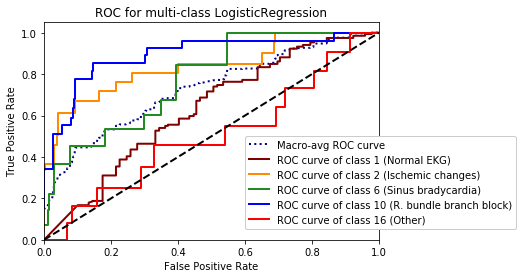

In [40]:
log_reg_classifier = one_vs_rest_logistic_regression_classifier(
    X_train, y_train, X_test, y_test, seed=RANDOM_SEED, over=10)

## Logistic regression: Averaging across sensors

In [41]:
def prefixes_item(prefixes, item):
    return [prefix + '_' + item for prefix in prefixes]

base_col_names = [col for col in ColNames.base_col_names if col in X.columns]
Xavg = X[base_col_names].copy()
for t_attr in ColNames.t_attrs:
    t_cols = [col for col in prefixes_item(ColNames.sensors, t_attr) if col in X.columns]
    def avg_cols(row):
        return sum([row[col] for col in t_cols]) / len(t_cols)

    Xavg[t_attr] = X[t_cols].apply(avg_cols, axis=1)

for v_attr in ColNames.v_attrs:
    v_cols = [col for col in prefixes_item(ColNames.sensors, v_attr) if col in X.columns]
    def avg_cols(row):
        return sum([row[col] for col in v_cols]) / len(v_cols)
    
    Xavg[v_attr] = X[v_cols].apply(avg_cols, axis=1)

In [42]:
Xavg.sample()

,age,sex,height,weight,qrs_duration_msec,p_onset_to_q_onset_msec,q_onset_to_t_offset_msec,duration_between_t_waves_msec,duration_between_p_waves_msec,qrs_front_plane_deg,heart_rate_bpm,q_width_msec,r_width_msec,s_width_msec,r2_width_msec,s2_width_msec,intrinsic_deflections,is_present_diphasic_r,is_present_notched_r,is_present_notched_p,is_present_diphasic_p,is_present_notched_t,is_present_diphasic_t,j_point_depression_mvolt,q_amplitude_mvolt,r_amplitude_mvolt,s_amplitude_mvolt,r2_amplitude_mvolt,s2_amplitude_mvolt,p_amplitude_mvolt,t_amplitude_mvolt,qrsa,qrsta
314,64,0,167,72,85,154,352,152,69,13,70.0,7.666667,36.666667,31.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,-0.75,4.941667,-3.125,0.0,0.0,0.225,1.608333,2.133333,16.15


In [43]:
Xavg_train, Xavg_test, yavg_train, yavg_test = train_test_split(
    Xavg, y, test_size=0.5, random_state=RANDOM_SEED, stratify=y)

In [44]:
Xavg_train.shape, yavg_train.shape, Xavg_test.shape, yavg_test.shape

((193, 33), (193,), (193, 33), (193,))

Shapes of X_train     , y_train     , X_test     , y_test      = (193, 33), (193,), (193, 33), (193,)
Shapes of X_train_over, y_train_over, X_test_over, y_test_over = (6150, 33), (6150,), (6100, 33), (6100,)


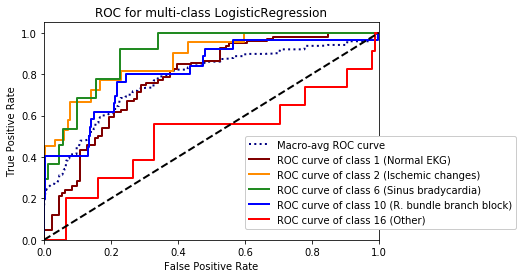

OneVsRestClassifier(estimator=LogisticRegression(C=5.7664087182586385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1)

In [45]:
one_vs_rest_logistic_regression_classifier(Xavg_train, yavg_train, Xavg_test, yavg_test
                                           , seed=RANDOM_SEED, over=10)

<hr style="height:5px;margin:auto;width:100%"/>

# Distribution of Logistic Regression ROC AUC values

In [46]:
runs_columns = '''full_macro
                full_1 full_2 full_6 full_10 full_16
                avg_macro
                avg_1 avg_2 avg_6 avg_10 avg_16'''.split()

runs = {}
runs[40] = [0.7061, 0.6942, 0.8541, 0.8049, 0.9012, 0.2727
            , 0.7457, 0.7286, 0.8901, 0.9285, 0.8216, 0.3568]
runs[41] = [0.7515, 0.7143, 0.8357, 0.8885, 0.8938, 0.4226
            , 0.7748, 0.7399, 0.9053, 0.8588, 0.8103, 0.5547]
runs[42] = [0.7336, 0.6413, 0.8434, 0.8298, 0.9111, 0.4395
            , 0.7542, 0.7238, 0.9035, 0.9214, 0.8270, 0.3892]
runs[43] = [0.7834, 0.6727, 0.9121, 0.8331, 0.8444, 0.6514
            , 0.7452, 0.6471, 0.8568, 0.9236, 0.6640, 0.6309]
runs[44] = [0.7382, 0.7205, 0.8616, 0.6976, 0.8928, 0.5142
            , 0.8195, 0.7721, 0.8716, 0.9186, 0.8955, 0.6368]
runs[45] = [0.7502, 0.6644, 0.7804, 0.8805, 0.9358, 0.4855
            , 0.7788, 0.6765, 0.9104, 0.9617, 0.7558, 0.5863]
runs[46] = [0.7576, 0.7022, 0.8578, 0.8415, 0.8858, 0.4963
            , 0.7676, 0.7519, 0.8961, 0.9141, 0.8152, 0.4573]
runs[47] = [0.7279, 0.6292, 0.8376, 0.7747, 0.8931, 0.5015
            , 0.7883, 0.7985, 0.8826, 0.8997, 0.8320, 0.5257]
runs[48] = [0.7928, 0.7004, 0.8722, 0.9233, 0.9578, 0.5061
            , 0.8030, 0.7669, 0.8924, 0.9417, 0.8617, 0.5489]
runs[49] = [0.7296, 0.5994, 0.8407, 0.8198, 0.9165, 0.4675
            , 0.7712, 0.7425, 0.8903, 0.9238, 0.8249, 0.4713]
runs[50] = [0.7469, 0.5645, 0.8406, 0.8677, 0.9408, 0.5172
            , 0.7874, 0.7115, 0.8480, 0.9160, 0.8422, 0.6161]
runs[51] = [0.6996, 0.6415, 0.8434, 0.8246, 0.8565, 0.3285
            , 0.7823, 0.7326, 0.9398, 0.9526, 0.7512, 0.5323]
runs[52] = [0.7508, 0.7099, 0.8545, 0.8219, 0.9185, 0.4455
            , 0.7266, 0.7567, 0.8773, 0.8701, 0.7817, 0.3429]
runs[53] = [0.7367, 0.6333, 0.8858, 0.8447, 0.8930, 0.4232
            , 0.7070, 0.6980, 0.8649, 0.9079, 0.6310, 0.4298]
runs[54] = [0.7107, 0.6490, 0.8006, 0.8999, 0.9037, 0.2958
            , 0.7400, 0.6700, 0.7927, 0.9391, 0.7751, 0.5202]
runs[55] = [0.7405, 0.6774, 0.8825, 0.8046, 0.9391, 0.3964
            , 0.7806, 0.7476, 0.8946, 0.8896, 0.8411, 0.5274]
runs[56] = [0.7532, 0.6763, 0.8265, 0.8934, 0.9161, 0.4507
            , 0.7553, 0.7390, 0.9058, 0.9492, 0.7999, 0.3796]
runs[57] = [0.7275, 0.6833, 0.7752, 0.8357, 0.9073, 0.4325
            , 0.7723, 0.7114, 0.8856, 0.9380, 0.7498, 0.5726]
runs[58] = [0.7378, 0.6461, 0.8453, 0.9032, 0.9117, 0.3794
            , 0.7443, 0.7016, 0.8781, 0.9504, 0.7556, 0.4327]
runs[59] = [0.7295, 0.6148, 0.8178, 0.8655, 0.9293, 0.4174
            , 0.7680, 0.7176, 0.8431, 0.9307, 0.8361, 0.5090]
runs[60] = [0.7104, 0.6793, 0.8798, 0.6139, 0.9331, 0.4426
            , 0.7682, 0.7143, 0.8890, 0.8483, 0.7949, 0.5910]
runs[61] = [0.7554, 0.5891, 0.8027, 0.9204, 0.9258, 0.5356
            , 0.7750, 0.7906, 0.8840, 0.9263, 0.8665, 0.4442]
runs[62] = [0.7442, 0.7098, 0.8538, 0.8561, 0.8500, 0.4475
            , 0.7582, 0.7314, 0.8600, 0.9107, 0.8100, 0.4752]
runs[63] = [0.7024, 0.6409, 0.8642, 0.7816, 0.8375, 0.3845
            , 0.6990, 0.6471, 0.8640, 0.9429, 0.6615, 0.3747]
runs[64] = [0.7406, 0.6180, 0.8721, 0.8480, 0.8885, 0.4726
            , 0.7814, 0.7107, 0.8950, 0.9476, 0.8476, 0.5030]

In [47]:
runs_array = np.array(list(runs.values()))
runs_df = pd.DataFrame(runs_array, columns=runs_columns)

In [48]:
runs_df.mean()

full_macro    0.738284
full_1        0.658872
full_2        0.845616
full_6        0.834996
full_10       0.903328
full_16       0.445068
avg_macro     0.763756
avg_1         0.725116
avg_2         0.880840
avg_6         0.920452
avg_10        0.794088
avg_16        0.496344
dtype: float64

In [49]:
runs_df.std() / sqrt(runs_df.shape[0])

full_macro    0.004518
full_1        0.008412
full_2        0.006504
full_6        0.013642
full_10       0.006228
full_16       0.015869
avg_macro     0.005478
avg_1         0.007777
avg_2         0.005634
avg_6         0.005813
avg_10        0.013092
avg_16        0.017408
dtype: float64